# Gesundheitsministerium and ECDC Data

## Setup

### Imports

In [79]:
%matplotlib notebook

import logging
import calendar
import numpy as np
from datetime import timedelta
from matplotlib import pyplot as plt
from helper import *
from austria import Austria
from ecdc import ECDC
ecdc = ECDC()
AT = Austria()
logging.basicConfig(level=logging.INFO)
plt.style.use('seaborn-darkgrid')

# df_ecdc = ecdc()
# logging.info('ECDC: \n%s', df_ecdc.columns)



## Cases

<IPython.core.display.Javascript object>


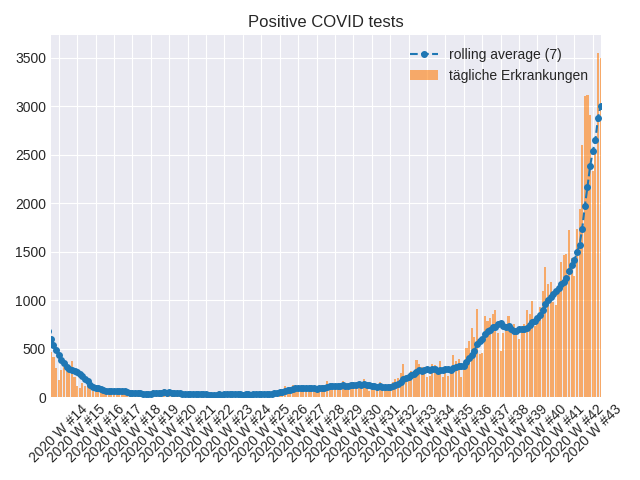

[Timestamp('2020-04-02 00:00:00'), Timestamp('2020-10-28 00:00:00')]


In [80]:
ax = AT.plot_tägliche_erkrankungen(roll_days=7,ndays=210, log=False)


In [81]:
import pandas as pd
AT.epicurve.time.max()

Timestamp('2020-10-28 00:00:00')

## Weekday Bias

<IPython.core.display.Javascript object>


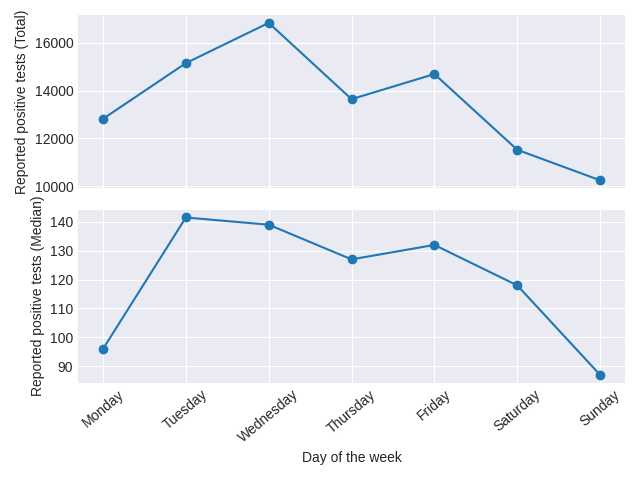

In [82]:
f, ax = plt.subplots(nrows=2, sharex=True)
AT.epicurve.groupby(['weekday']).sum()['tägliche Erkrankungen'].plot(ax=ax[0], marker='o')
ax[0].set_ylabel('Reported positive tests (Total)')
AT.epicurve.groupby(['weekday']).median()['tägliche Erkrankungen'].plot(ax=ax[1], marker='o')
ax[1].set_ylabel('Reported positive tests (Median)')
ax[1].set_xlabel('Day of the week')
ax[1].set_xticks([0,1,2,3,4,5,6])
ax[1].set_xticklabels(WEEKDAYS, rotation=40)
plt.tight_layout()

## Comparison with ECDC data

### Number of cases

In [83]:
AT.epicurve['tägliche Erkrankungen'].sum(), ecdc.select_country('AT').cases.sum()


(94891, 91895)

### Plots overlaid

<IPython.core.display.Javascript object>


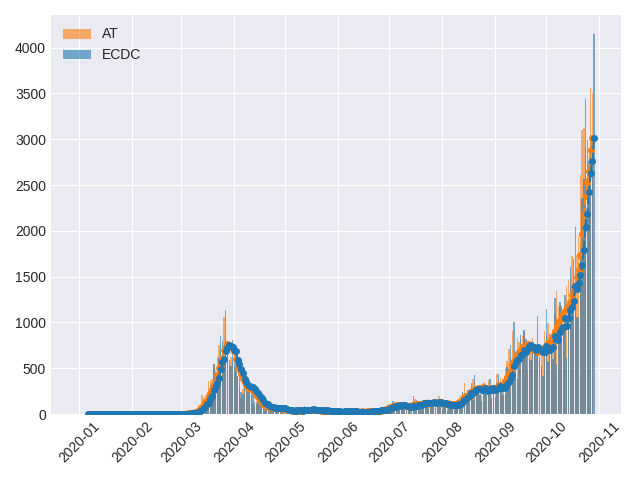

In [84]:
f,ax = plt.subplots()
# ax.bar(df_at.time, df_at['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')

ax.plot(AT.epicurve.time, AT.epicurve['tägliche Erkrankungen'].rolling(7).mean(),  marker='o', markersize=4, linestyle='--', color='C1')

ax.bar(AT.epicurve.time, AT.epicurve['tägliche Erkrankungen'],label='AT',  alpha=0.6, color='C1')
selection =  ecdc.select_country('AT').sort_values(by=['year','month','day'], ascending=True)
ax.bar(selection.dateRep, selection['cases'],label='ECDC',  alpha=0.6, color='C0')
ax.plot(selection.dateRep, selection['cases'].rolling(7).mean(), marker='o', markersize=4, linestyle='--',color='C0')
# plt.yscale('log')


plt.xticks(rotation=45);
plt.legend(loc='best')
plt.tight_layout()



### Last 5 days

In [67]:
 ecdc.select_country('AT').sort_values('dateRep')[['dateRep', 'cases', 'deaths','popData2019', 'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000' ]].tail(6)

,dateRep,cases,deaths,popData2019,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
2772,2020-10-23,2570,17,8858775.0,234.072995
2771,2020-10-24,3442,15,8858775.0,259.595712
2770,2020-10-25,2989,6,8858775.0,283.165562
2769,2020-10-26,2766,6,8858775.0,299.736702
2768,2020-10-27,2512,4,8858775.0,321.229515
2767,2020-10-28,2698,18,8858775.0,338.466662


In [68]:
AT.epicurve.sort_values('time').tail(5)

,time,tägliche Erkrankungen,Timestamp,weekday
241,2020-10-23,3044,2020-10-28T14:02:01,4
242,2020-10-24,2916,2020-10-28T14:02:01,5
243,2020-10-25,2380,2020-10-28T14:02:01,6
244,2020-10-26,2441,2020-10-28T14:02:01,0
245,2020-10-27,3160,2020-10-28T14:02:01,1


In [69]:
AT.epicurve.time.max()

Timestamp('2020-10-27 00:00:00')

In [70]:
AT.epicurve.agg(
        {'tägliche Erkrankungen': ['sum', last_7_days_sum,  rolling_avg, latest,  'max' ],
        'time': ['min', 'max']} )


,tägliche Erkrankungen,time
last_7_days_sum,19559.000000,NaT
latest,3160.000000,NaT
max,3160.000000,2020-10-27
min,NaN,2020-02-25
rolling_avg,2794.142857,NaT
sum,90629.000000,NaT


In [71]:
ecdc.compact_overview(ecdc.select_country('AT'))

cases              deaths                  \
                         rolling_avg latest   max    sum last_7_days_sum   
countriesAndTerritories                                                    
Austria                  2761.714286   2698  3442   1006              79   

                                                
                        rolling_avg latest max  
countriesAndTerritories                         
Austria                   11.285714     18  31

## Number of Tests and Positives

### Vienna

In [74]:
wien_cases = AT.fall_zählen[AT.fall_zählen.Bundesland=='Wien']
wien_timeline = AT.fälle_timeline_gkz[AT.fälle_timeline_gkz.Bezirk=='Wien']


In [76]:
wien_cases.iloc[-1].MeldeDatum

Timestamp('2020-10-28 00:00:00')

<IPython.core.display.Javascript object>


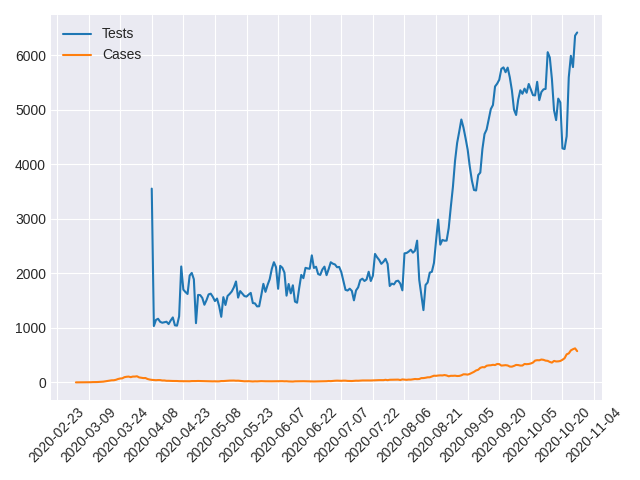

In [16]:
f, ax = plt.subplots()
ax.plot(wien_cases.MeldeDatum, wien_cases.TestGesamt.diff().rolling(7).mean(), label='Tests')
ax.plot(wien_timeline.Time, wien_timeline.AnzahlFaelle.rolling(7).mean(), label='Cases')
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.legend(loc='best')
# plt.yscale('log')

plt.xticks(rotation=45);
plt.tight_layout()

<IPython.core.display.Javascript object>


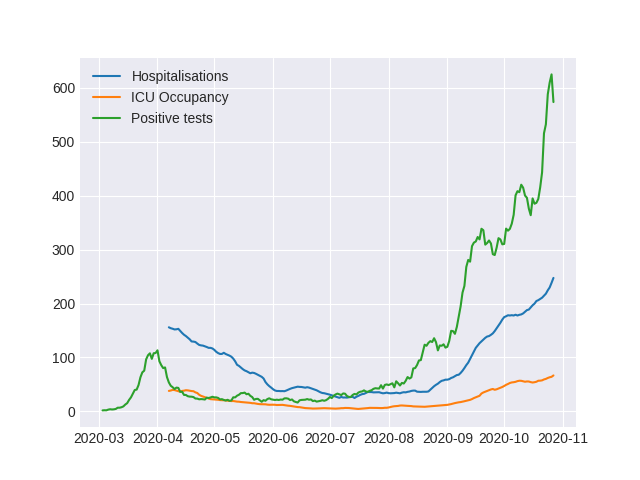

In [17]:
f, ax = plt.subplots()
ax.plot(wien_cases.MeldeDatum, wien_cases.FZHosp.rolling(7).mean(), label='Hospitalisations')
ax.plot(wien_cases.MeldeDatum, wien_cases.FZICU.rolling(7).mean(), label='ICU Occupancy')
ax.plot(wien_timeline.Time, wien_timeline.AnzahlFaelle.rolling(7).mean(), label='Positive tests')
# ax.plot(wien_cases.MeldeDatum, wien_cases.TestGesamt.diff().rolling(7).mean(), label='Total Tests')
# plt.yscale('log')

# ax.plot(df_at.time, df_at['tägliche Erkrankungen'].rolling(7).mean(), label='Epicurve')
# plt.yscale('log')
plt.legend(loc='best')
#  Index(['Time', 'Bezirk', 'GKZ', 'AnzEinwohner', 'AnzahlFaelle',
#        'AnzahlFaelleSum', 'AnzahlFaelle7Tage', 'SiebenTageInzidenzFaelle',
#        'AnzahlTotTaeglich', 'AnzahlTotSum', 'AnzahlGeheiltTaeglich',
#        'AnzahlGeheiltSum'],

#  Index(['Meldedat', 'TestGesamt', 'MeldeDatum', 'FZHosp', 'FZICU', 'FZHospFree','FZICUFree', 'BundeslandID', 'Bundesland'],


In [42]:

AT.epicurve.columns

Index(['time', 'tägliche Erkrankungen', 'Timestamp', 'weekday'], dtype='object')

### Ratio of positives to tests

In [38]:
def moving_average(a, n=3) :
    ret = np.cumsum(a)
    print(ret)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [49]:
ratio[:2]

array([   nan, 18828.])

<IPython.core.display.Javascript object>


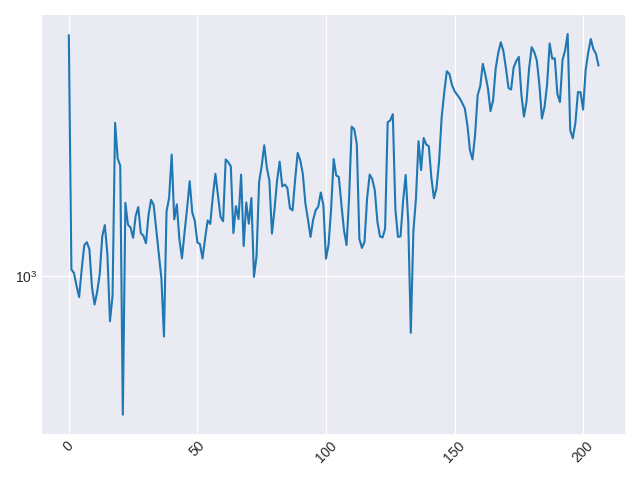

[ 18828.  19498.  20612.  21995.  22579.  23392.  24536.  25748.  27234.
  28475.  29471.  29988.  30869.  32113.  33028.  34996.  36627.  36611.
  37091.  39191.  46828.  44784.  46439.  47820.  50174.  50967.  52251.
  54253.  55824.  57464.  58488.  59969.  61371.  63391.  65495.  66671.
  67759.  69120.  69622.  69613.  74157.  75231.  77550.  78882.  80558.
  81584.  82346.  84814.  86747.  88759.  89815.  91414.  92689.  93694.
  94873.  96749.  98381.  99430. 102418. 105183. 105168. 107236. 109840.
 112797. 114704. 117054. 117033. 119959. 121793. 123795. 123779. 127206.
 128361. 129388. 130193. 131877. 135755. 137428. 140426. 142914. 143864.
 144643. 148043. 150319. 152143. 154196. 156565. 158213. 159357. 161646.
 164684. 167392. 169230. 171483. 172765. 173956. 175593. 177466. 179041.
 180824. 183325. 184328. 184278. 187173. 189448. 191930. 193882. 196084.
 197271. 198226. 199935. 202871. 208145. 209648. 211500. 212187. 213411.
 215454. 217779. 220174. 221979. 223740. 224824. 22

In [52]:
# ax.plot(wien_cases.MeldeDatum, wien_cases.FZHosp.rolling(7).mean(), label='Hospitalisations')
# ax.plot(wien_cases.MeldeDatum, wien_cases.FZICU.rolling(7).mean(), label='ICU Occupancy')
# ax.plot(wien_timeline.Time, wien_timeline.AnzahlFaelle.rolling(7).mean(), label='Positive tests')
# ax.plot(wien_cases.MeldeDatum, wien_cases.TestGesamt.diff().rolling(7).mean(), label='Total Tests')
wien_timeline = wien_timeline.fillna(0)
wien_cases = wien_cases.fillna(0)
f,ax=plt.subplots()
ratio = np.array(-wien_timeline[wien_timeline.Time.isin(wien_cases.MeldeDatum)].AnzahlFaelle)+np.array(wien_cases.TestGesamt.diff())
ax.plot(moving_average(ratio[1:]))
plt.yscale('log')

plt.xticks(rotation=45);
plt.tight_layout()

print(moving_average(ratio[1:]))

## Corona Ampel

In [44]:
ampel = AT.ampel_aktuell

ampel.sort_values('Warnstufe', ascending=False).head(10)

,Region,GKZ,Name,Warnstufe
93,Gemeinde,80104,Bludesch,4
115,Gemeinde,80126,Thüringen,4
142,Gemeinde,80224,Lauterach,4
138,Gemeinde,80220,Kennelbach,4
137,Gemeinde,80219,Hohenweiler,4
136,Gemeinde,80218,Hörbranz,4
135,Gemeinde,80217,Höchst,4
133,Gemeinde,80215,Hard,4
132,Gemeinde,80214,Gaißau,4
131,Gemeinde,80213,Fußach,4


## ICU Beds

<IPython.core.display.Javascript object>


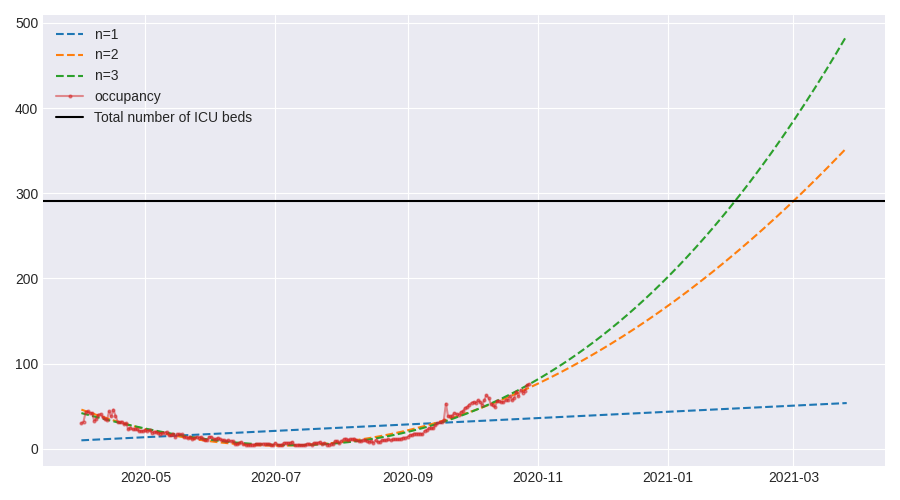

In [95]:
icu_occupancy = np.array(wien_cases.FZICU)
ndays = np.arange(len(icu_occupancy))
predict_days=150
future = np.arange(ndays[0],ndays[-1]+predict_days)
future_days = pd.date_range(start =wien_cases.iloc[0].MeldeDatum, end = wien_cases.iloc[-1].MeldeDatum + timedelta(days=predict_days-1)).to_list()
z1 = np.polyfit(ndays, icu_occupancy, 1)
p1 = np.poly1d(z1)
z2 = np.polyfit(ndays, icu_occupancy, 2)
p2 = np.poly1d(z2)
z3 = np.polyfit(ndays, icu_occupancy, 3)
p3 = np.poly1d(z3)
z4 = np.polyfit(ndays, icu_occupancy, 4)
p4 = np.poly1d(z4)
z5 = np.polyfit(ndays, icu_occupancy, 5)
p5 = np.poly1d(z5)

f, ax = plt.subplots(figsize=(9,5))
ax.plot(future_days, p1(future), linestyle='--', label='n=1')
ax.plot(future_days, p2(future), linestyle='--', label='n=2')
ax.plot(future_days, p3(future), linestyle='--', label='n=3')
ax.plot(wien_cases.MeldeDatum, icu_occupancy, label='occupancy', marker='o', alpha=0.5,markersize=2)



ax.axhline(y=215+76,color='k', label='Total number of ICU beds')
plt.legend(loc='best')
plt.tight_layout()

## Deaths

In [96]:
from gestorbene import Gestorbene
G = Gestorbene()

### Overall Deaths

<IPython.core.display.Javascript object>


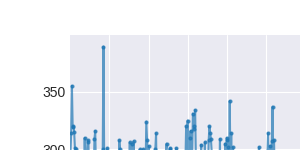

In [97]:
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='Y',closed='left')
f, ax = plt.subplots(figsize=(9,6), sharex=True, nrows=2)
G.under_65.groupby(['week_end']).sum()['F-ANZ-1'].plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(['week_end']).sum()['F-ANZ-1'].plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.ylabel('Number of deaths')
plt.xticks(dates, dates.strftime('%Y'))
plt.tight_layout()

### Group by month and year

<IPython.core.display.Javascript object>


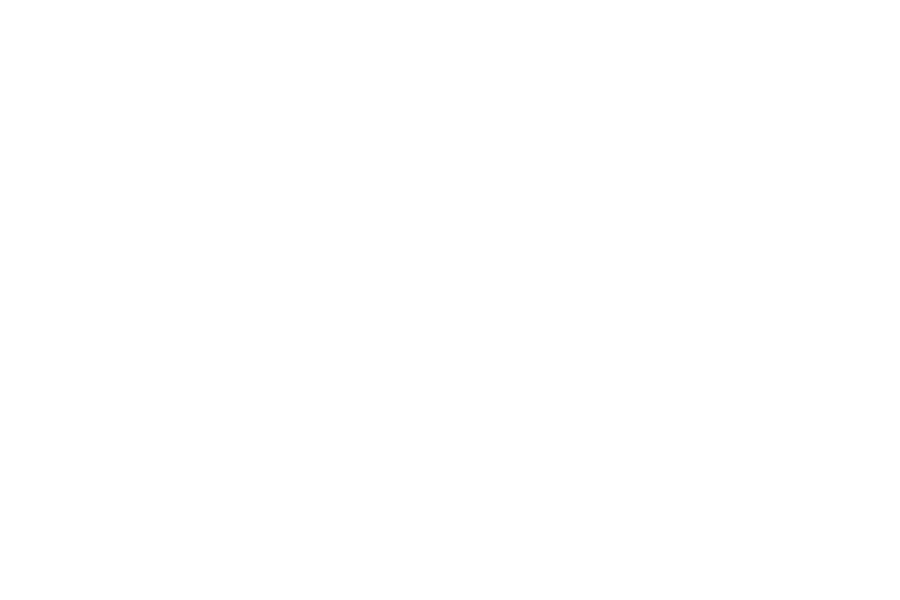

In [48]:
from matplotlib.ticker import FormatStrFormatter
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='M')

f, ax = plt.subplots(figsize=(9,6), sharex=True,nrows=2)
G.under_65.groupby(by=[G.under_65.week_end.dt.year, G.under_65.week_end.dt.month]).sum()['F-ANZ-1'].plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(by=[G.over_65.week_end.dt.year, G.over_65.week_end.dt.month]).sum()['F-ANZ-1'].plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.ylabel('Number of deaths')
ax[1].xaxis.set_major_locator(plt.MaxNLocator(50));

# plt.xticks(dates,zip( dates.strftime('%Y'),dates.strftime('%M')));
# ax[1].xaxis.set_major_formatter(FormatStrFormatter('%Y'));

# plt.tight_layout()

### By Gender

<IPython.core.display.Javascript object>


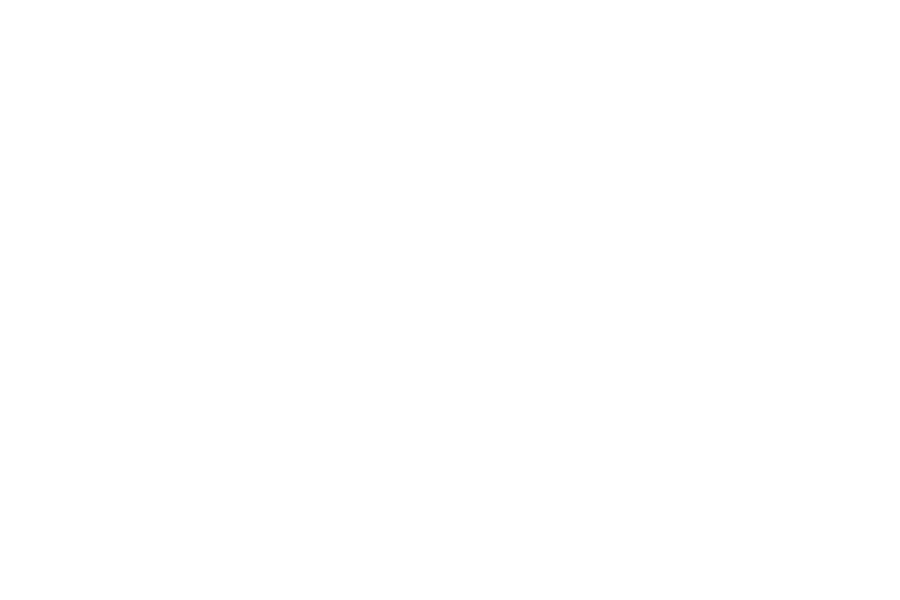

In [49]:
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='Y',closed='left')
f, ax = plt.subplots(figsize=(9,6), sharex=True, nrows=2)
G.under_65.groupby(['week_end','sex']).sum()['F-ANZ-1'].unstack().plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(['week_end','sex']).sum()['F-ANZ-1'].unstack().plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.xticks(rotation=45)

plt.ylabel('Number of deaths')
plt.xticks(dates, dates.strftime('%Y-%m'));
plt.tight_layout()

### Monthly